#### Import packages

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import pickle
from matplotlib.ticker import PercentFormatter
import scipy
import statsmodels.api as sm 
plt.rcParams['figure.dpi'] = 500
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})

#### Ploting functions

In [3]:
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type
import statsmodels

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """
    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """
        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)
        '''
        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')
        '''
        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)
        '''
        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')
        '''
        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax
    
    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)
        '''
        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        '''
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax
    
    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax
    
    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

In [4]:
# Read data
CAPACITY = pickle.load( open( 'Sim1220CAPACITY.p', 'rb' ) )

In [5]:
df1 = pd.DataFrame (CAPACITY['Throughput'], columns = ['scenario','run_time','2021Q1','2021Q2','2021Q3','2021Q4','2022Q1','2022Q2','2022Q3','2022Q4','2023Q1','2023Q2','2023Q3'])

In [6]:
CAPACITY.keys()

dict_keys(['Throughput', 'Risk1'])

In [7]:
df2 = pd.DataFrame (CAPACITY['Risk1'], columns = ['scenario','run_time','2021Q1','2021Q2','2021Q3','2021Q4','2022Q1','2022Q2','2022Q3','2022Q4','2023Q1','2023Q2','2023Q3'])

In [8]:
statistics.stdev(df2['2022Q1'][:100] + df1['2021Q2'][:100] + df1['2021Q3'][:100]+ df1['2021Q4'][:100]+ df1['2021Q1'][:100])

2.0171987777834164

In [9]:
statistics.stdev(df2['2022Q1'][:100])

2.039285872232451

In [10]:
statistics.mean(df2['2022Q1'][:100])

47.77

In [11]:
statistics.mean(df2['2022Q1'][:100] + df1['2021Q2'][:100] + df1['2021Q3'][:100]+ df1['2021Q4'][:100]+ df1['2021Q1'][:100])

221.46

In [12]:
new_column = ['Core','Labor','Backend','NewStart','BayPair']
NAME_LIST = {'Core':[],'Labor':[],'Backend':[],'NewStart':[],'BayPair':[]}

In [13]:
for K in CAPACITY['Risk1']:
    N = K[0]
    n2 = N.split('_')
    i = 0
    for k in ['Core','Labor','Backend','NewStart','BayPair']:
        if k in ['Core','Backend']:
            if n2[i] == 'True':
                a = 'Delay'
            else:
                a = 'Not delay'
        elif k == 'Labor':
            if n2[i] == 'True':
                a = 'Full labor'
            else:
                a = 'Shortage labor'
        elif k == 'BayPair':
            a = (int(n2[i]),int(n2[i+1]))
        else:
            a = int(n2[i])
        NAME_LIST[k].append(a)
        i += 1

In [14]:
for i in range(len(new_column)):
    df1.insert(2,new_column[-i-1],NAME_LIST[new_column[-i-1]],True)

In [15]:
yearly_throughput = []
for index, item in df1.iterrows():
    yearly_throughput.append(sum([item['2022Q3'],item['2022Q4'],item['2023Q1'],item['2023Q2']]))

In [16]:
df1 = df1.assign(annual = yearly_throughput)

In [17]:
df1 = df1.drop_duplicates(subset=['scenario', 'run_time'])
df1 = df1.reset_index(drop = True)

In [67]:
df1.to_excel('throughput_1221.xlsx')

In [68]:
df2.to_excel('fail_to_finish_1221.xlsx')

In [93]:
s1 = []
s2 = []
s3 = []
s4 = []
for index, item in df1.iterrows():
    if item[0] == "True_True_True_6_19_15_True_0.85_8_7.p":
        s4.append(item["2023Q2"])
        s3.append(item["2023Q1"])
        s2.append(item["2022Q4"])
        s1.append(item["2022Q3"])

In [94]:
statistics.mean(s1) + statistics.mean(s2) + statistics.mean(s3) + statistics.mean(s4)

308.14

In [74]:
print(statistics.mean(s1), statistics.mean(s2), statistics.mean(s3), statistics.mean(s4))

92.59 86.06 84.35 80.69


In [19]:
N = len(df1)
VARIABLE_NAMES = ['Core=Delay','Core=Not delay','Labor=Full labor','Labor=Shortage labor',
                   'Backend=Delay','Backend=Not delay','NewStart=6','NewStart=8','NewStart=10',
                   'BayPair=(19,15)','BayPair=(19,16)','BayPair=(18,16)','BayPair=(19,17)',
                   'BayPair=(20,15)','BayPair=(20,16)','BayPair=(20,17)',
                  'Interaction(Core = Not delay,Labor = Full labor)',
                  'Interaction(Core = Not delay,Backend = Not delay)',
                  'Interaction(Core = Not delay,NewStart = 10)',
                  'Interaction(Core = Not delay,NewStart = 8)',
                  'Interaction(Core = Not delay,BayPair = (18, 16))',
                  'Interaction(Core = Not delay,BayPair = (19, 16))',
                  'Interaction(Core = Not delay,BayPair = (19, 17))',
                  'Interaction(Core = Not delay,BayPair = (20, 15))',
                  'Interaction(Core = Not delay,BayPair = (20, 16))',
                  'Interaction(Core = Not delay,BayPair = (20, 17))',
                  'Interaction(Labor = Full labor,Backend = Not delay)',
                  'Interaction(Labor = Full labor,NewStart = 10)',
                  'Interaction(Labor = Full labor,NewStart = 8)',
                  'Interaction(Labor = Full labor,BayPair = (18, 16))',
                  'Interaction(Labor = Full labor,BayPair = (19, 16))',
                  'Interaction(Labor = Full labor,BayPair = (19, 17))',
                  'Interaction(Labor = Full labor,BayPair = (20, 15))',
                  'Interaction(Labor = Full labor,BayPair = (20, 16))',
                  'Interaction(Labor = Full labor,BayPair = (20, 17))',
                  'Interaction(Backend = Not delay,NewStart = 10)',
                  'Interaction(Backend = Not delay,NewStart = 8)',
                  'Interaction(Backend = Not delay,BayPair = (18, 16))',
                  'Interaction(Backend = Not delay,BayPair = (19, 16))',
                  'Interaction(Backend = Not delay,BayPair = (19, 17))',
                  'Interaction(Backend = Not delay,BayPair = (20, 15))',
                  'Interaction(Backend = Not delay,BayPair = (20, 16))',
                  'Interaction(Backend = Not delay,BayPair = (20, 17))',
                  'Interaction(NewStart = 10,BayPair = (18, 16))',
                  'Interaction(NewStart = 10,BayPair = (19, 16))',
                  'Interaction(NewStart = 10,BayPair = (19, 17))',
                  'Interaction(NewStart = 10,BayPair = (20, 15))',
                  'Interaction(NewStart = 10,BayPair = (20, 16))',
                  'Interaction(NewStart = 10,BayPair = (20, 17))',
                  'Interaction(NewStart = 8,BayPair = (18, 16))',
                  'Interaction(NewStart = 8,BayPair = (19, 16))',
                  'Interaction(NewStart = 8,BayPair = (19, 17))',
                  'Interaction(NewStart = 8,BayPair = (20, 15))',
                  'Interaction(NewStart = 8,BayPair = (20, 16))',
                  'Interaction(NewStart = 8,BayPair = (20, 17))',   
                  ]
VARIABLE_VALUES = {}
for key in VARIABLE_NAMES:
    VARIABLE_VALUES[key] = [0 for i in range(N)]

In [20]:
VARIABLE_VALUES.keys()

dict_keys(['Core=Delay', 'Core=Not delay', 'Labor=Full labor', 'Labor=Shortage labor', 'Backend=Delay', 'Backend=Not delay', 'NewStart=6', 'NewStart=8', 'NewStart=10', 'BayPair=(19,15)', 'BayPair=(19,16)', 'BayPair=(18,16)', 'BayPair=(19,17)', 'BayPair=(20,15)', 'BayPair=(20,16)', 'BayPair=(20,17)', 'Interaction(Core = Not delay,Labor = Full labor)', 'Interaction(Core = Not delay,Backend = Not delay)', 'Interaction(Core = Not delay,NewStart = 10)', 'Interaction(Core = Not delay,NewStart = 8)', 'Interaction(Core = Not delay,BayPair = (18, 16))', 'Interaction(Core = Not delay,BayPair = (19, 16))', 'Interaction(Core = Not delay,BayPair = (19, 17))', 'Interaction(Core = Not delay,BayPair = (20, 15))', 'Interaction(Core = Not delay,BayPair = (20, 16))', 'Interaction(Core = Not delay,BayPair = (20, 17))', 'Interaction(Labor = Full labor,Backend = Not delay)', 'Interaction(Labor = Full labor,NewStart = 10)', 'Interaction(Labor = Full labor,NewStart = 8)', 'Interaction(Labor = Full labor,BayPa

In [21]:
for index, item in df1.iterrows():
    if item['Core'] == "Delay":
        VARIABLE_VALUES['Core=Delay'][index] = 1
    else:
        VARIABLE_VALUES['Core=Not delay'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Core = Not delay,Labor = Full labor)'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,Backend = Not delay)'][index] = 1
    if item['Labor'] == 'Shortage labor':
        VARIABLE_VALUES['Labor=Shortage labor'][index] = 1
    else:
        VARIABLE_VALUES['Labor=Full labor'][index] = 1
        if item['Backend'] == "Not delay":
            VARIABLE_VALUES['Interaction(Labor = Full labor,Backend = Not delay)'][index] = 1
    if item['Backend'] == "Delay":
        VARIABLE_VALUES['Backend=Delay'][index] = 1
    else:
        VARIABLE_VALUES['Backend=Not delay'][index] = 1
    if item['NewStart'] == 6:
        VARIABLE_VALUES['NewStart=6'][index] = 1
    if item['NewStart'] == 8:
        VARIABLE_VALUES['NewStart=8'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,NewStart = 8)'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,NewStart = 8)'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,NewStart = 8)'][index] = 1
    if item['NewStart'] == 10:
        VARIABLE_VALUES['NewStart=10'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,NewStart = 10)'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,NewStart = 10)'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,NewStart = 10)'][index] = 1
    if item['BayPair'] == (19,15):
        VARIABLE_VALUES['BayPair=(19,15)'][index] = 1
    elif item['BayPair'] == (19,16):
        VARIABLE_VALUES['BayPair=(19,16)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (19, 16))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (19, 16))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (19, 16))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (19, 16))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (19, 16))'][index] = 1
    elif item['BayPair'] == (18,16):
        VARIABLE_VALUES['BayPair=(18,16)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (18, 16))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (18, 16))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (18, 16))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (18, 16))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (18, 16))'][index] = 1
    elif item['BayPair'] == (19,17):
        VARIABLE_VALUES['BayPair=(19,17)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (19, 17))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (19, 17))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (19, 17))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (19, 17))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (19, 17))'][index] = 1
    elif item['BayPair'] == (20,15):
        VARIABLE_VALUES['BayPair=(20,15)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (20, 15))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (20, 15))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (20, 15))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (20, 15))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (20, 15))'][index] = 1
    elif item['BayPair'] == (20,16):
        VARIABLE_VALUES['BayPair=(20,16)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (20, 16))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (20, 16))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (20, 16))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (20, 16))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (20, 16))'][index] = 1
    elif item['BayPair'] == (20,17):
        VARIABLE_VALUES['BayPair=(20,17)'][index] = 1
        if item['Core'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Core = Not delay,BayPair = (20, 17))'][index] = 1
        if item['Labor'] == 'Full labor':
            VARIABLE_VALUES['Interaction(Labor = Full labor,BayPair = (20, 17))'][index] = 1
        if item['Backend'] == 'Not delay':
            VARIABLE_VALUES['Interaction(Backend = Not delay,BayPair = (20, 17))'][index] = 1
        if item['NewStart'] == 8:
            VARIABLE_VALUES['Interaction(NewStart = 8,BayPair = (20, 17))'][index] = 1
        if item['NewStart'] == 10:
            VARIABLE_VALUES['Interaction(NewStart = 10,BayPair = (20, 17))'][index] = 1

In [22]:
df_X = pd.DataFrame.from_dict(VARIABLE_VALUES)

In [23]:
df1['scenario'][701]

'True_False_False_8_19_15_True_0.85_8_7.p'

In [24]:
df_X.iloc[701]

Core=Delay                                             1
Core=Not delay                                         0
Labor=Full labor                                       0
Labor=Shortage labor                                   1
Backend=Delay                                          0
Backend=Not delay                                      1
NewStart=6                                             0
NewStart=8                                             1
NewStart=10                                            0
BayPair=(19,15)                                        1
BayPair=(19,16)                                        0
BayPair=(18,16)                                        0
BayPair=(19,17)                                        0
BayPair=(20,15)                                        0
BayPair=(20,16)                                        0
BayPair=(20,17)                                        0
Interaction(Core = Not delay,Labor = Full labor)       0
Interaction(Core = Not delay,Ba

## Regression Main Effects

In [25]:
y = df1['annual']
X = df_X[['Core=Not delay','Labor=Full labor','Backend=Not delay','NewStart=10','NewStart=8',
          'BayPair=(19,16)','BayPair=(18,16)','BayPair=(19,17)','BayPair=(20,15)',
         'BayPair=(20,16)','BayPair=(20,17)']]

In [26]:
X = sm.add_constant(X)
model_main_effects = sm.OLS(y,X)
regr_main_effects = model_main_effects.fit()
regr_main_effects.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 annual   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     5588.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:26:49   Log-Likelihood:                -62378.
No. Observations:               16800   AIC:                         1.248e+05
Df Residuals:                   16788   BIC:                         1.249e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               299.7007      0.265   1130.566      0.000     299.181     300.220
Core=Not delay       20.7350      0.153    135.479      0.000      20.435      21.035
Labor=Full labor     20.0733      0.153    131.156      0.000      19.773      20.373
Backend=Not delay    21.3971      0.153    139.806      0.000      21.097      21.697
NewStart=10          12.5184      0.187     66.784      0.000      12.151      12.886
NewStart=8           12.1539      0.187     64.840      0.000      11.787      12.521
BayPair=(19,16)       3.2929      0.286     11.500      0.000       2.732       3.854
BayPair=(18,16)       1.4671      0.286      5.124      0.000       0.906       2.028
BayPair=(19,17)       4.6117      0.286     16.106      0.000       4.050       5.173
BayPair=(20,15)       0.8450      0.286      2.951      0.003       0.284       1.406
BayPair=(20,16)       4.0650      0.286     14.197      0.000       3.504       4.626
BayPair=(20,17)       5.1558      0.286     18.007      0.000       4.595       5.717
==============================================================================
Omnibus:                       80.772   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.081
Skew:                          -0.147   Prob(JB):                     3.35e-19
Kurtosis:                       3.188   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
residual_main_effects = regr_main_effects.resid

In [28]:
residual_main_effects

0         2.226012
1       -23.773988
2       -18.773988
3         8.226012
4         4.226012
           ...    
16795    -8.507024
16796    -7.507024
16797   -10.507024
16798   -15.507024
16799    -7.507024
Length: 16800, dtype: float64

In [29]:
X

const  Core=Not delay  Labor=Full labor  Backend=Not delay  \
0        1.0               0                 1                  0   
1        1.0               0                 1                  0   
2        1.0               0                 1                  0   
3        1.0               0                 1                  0   
4        1.0               0                 1                  0   
...      ...             ...               ...                ...   
16795    1.0               1                 0                  1   
16796    1.0               1                 0                  1   
16797    1.0               1                 0                  1   
16798    1.0               1                 0                  1   
16799    1.0               1                 0                  1   

       NewStart=10  NewStart=8  BayPair=(19,16)  BayPair=(18,16)  \
0                0           0                0                0   
1                0           0                0                0   
2                0           0                0                0   
3                0           0                0                0   
4                0           0                0                0   
...            ...         ...              ...              ...   
16795            1           0                0                0   
16796            1           0                0                0   
16797            1           0                0                0   
16798            1           0                0                0   
16799            1           0                0                0   

       BayPair=(19,17)  BayPair=(20,15)  BayPair=(20,16)  BayPair=(20,17)  
0                    0                0                0                0  
1                    0                0                0                0  
2                    0                0                0                0  
3                    0                0                0                0  
4                    0                0                0                0  
...                ...              ...              ...              ...  
16795                0                0                0                1  
16796                0                0                0                1  
16797                0                0                0                1  
16798                0                0                0                1  
16799                0                0                0                1  

[16800 rows x 12 columns]

In [30]:
cls = Linear_Reg_Diagnostic(regr_main_effects)

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

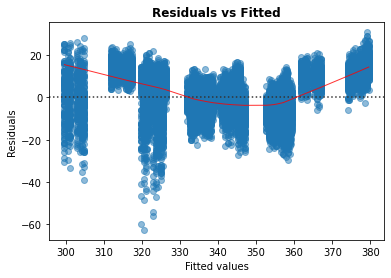

In [31]:
cls.residual_plot()
#In the graph red (roughly) horizontal line is an indicator that the residual has a linear pattern

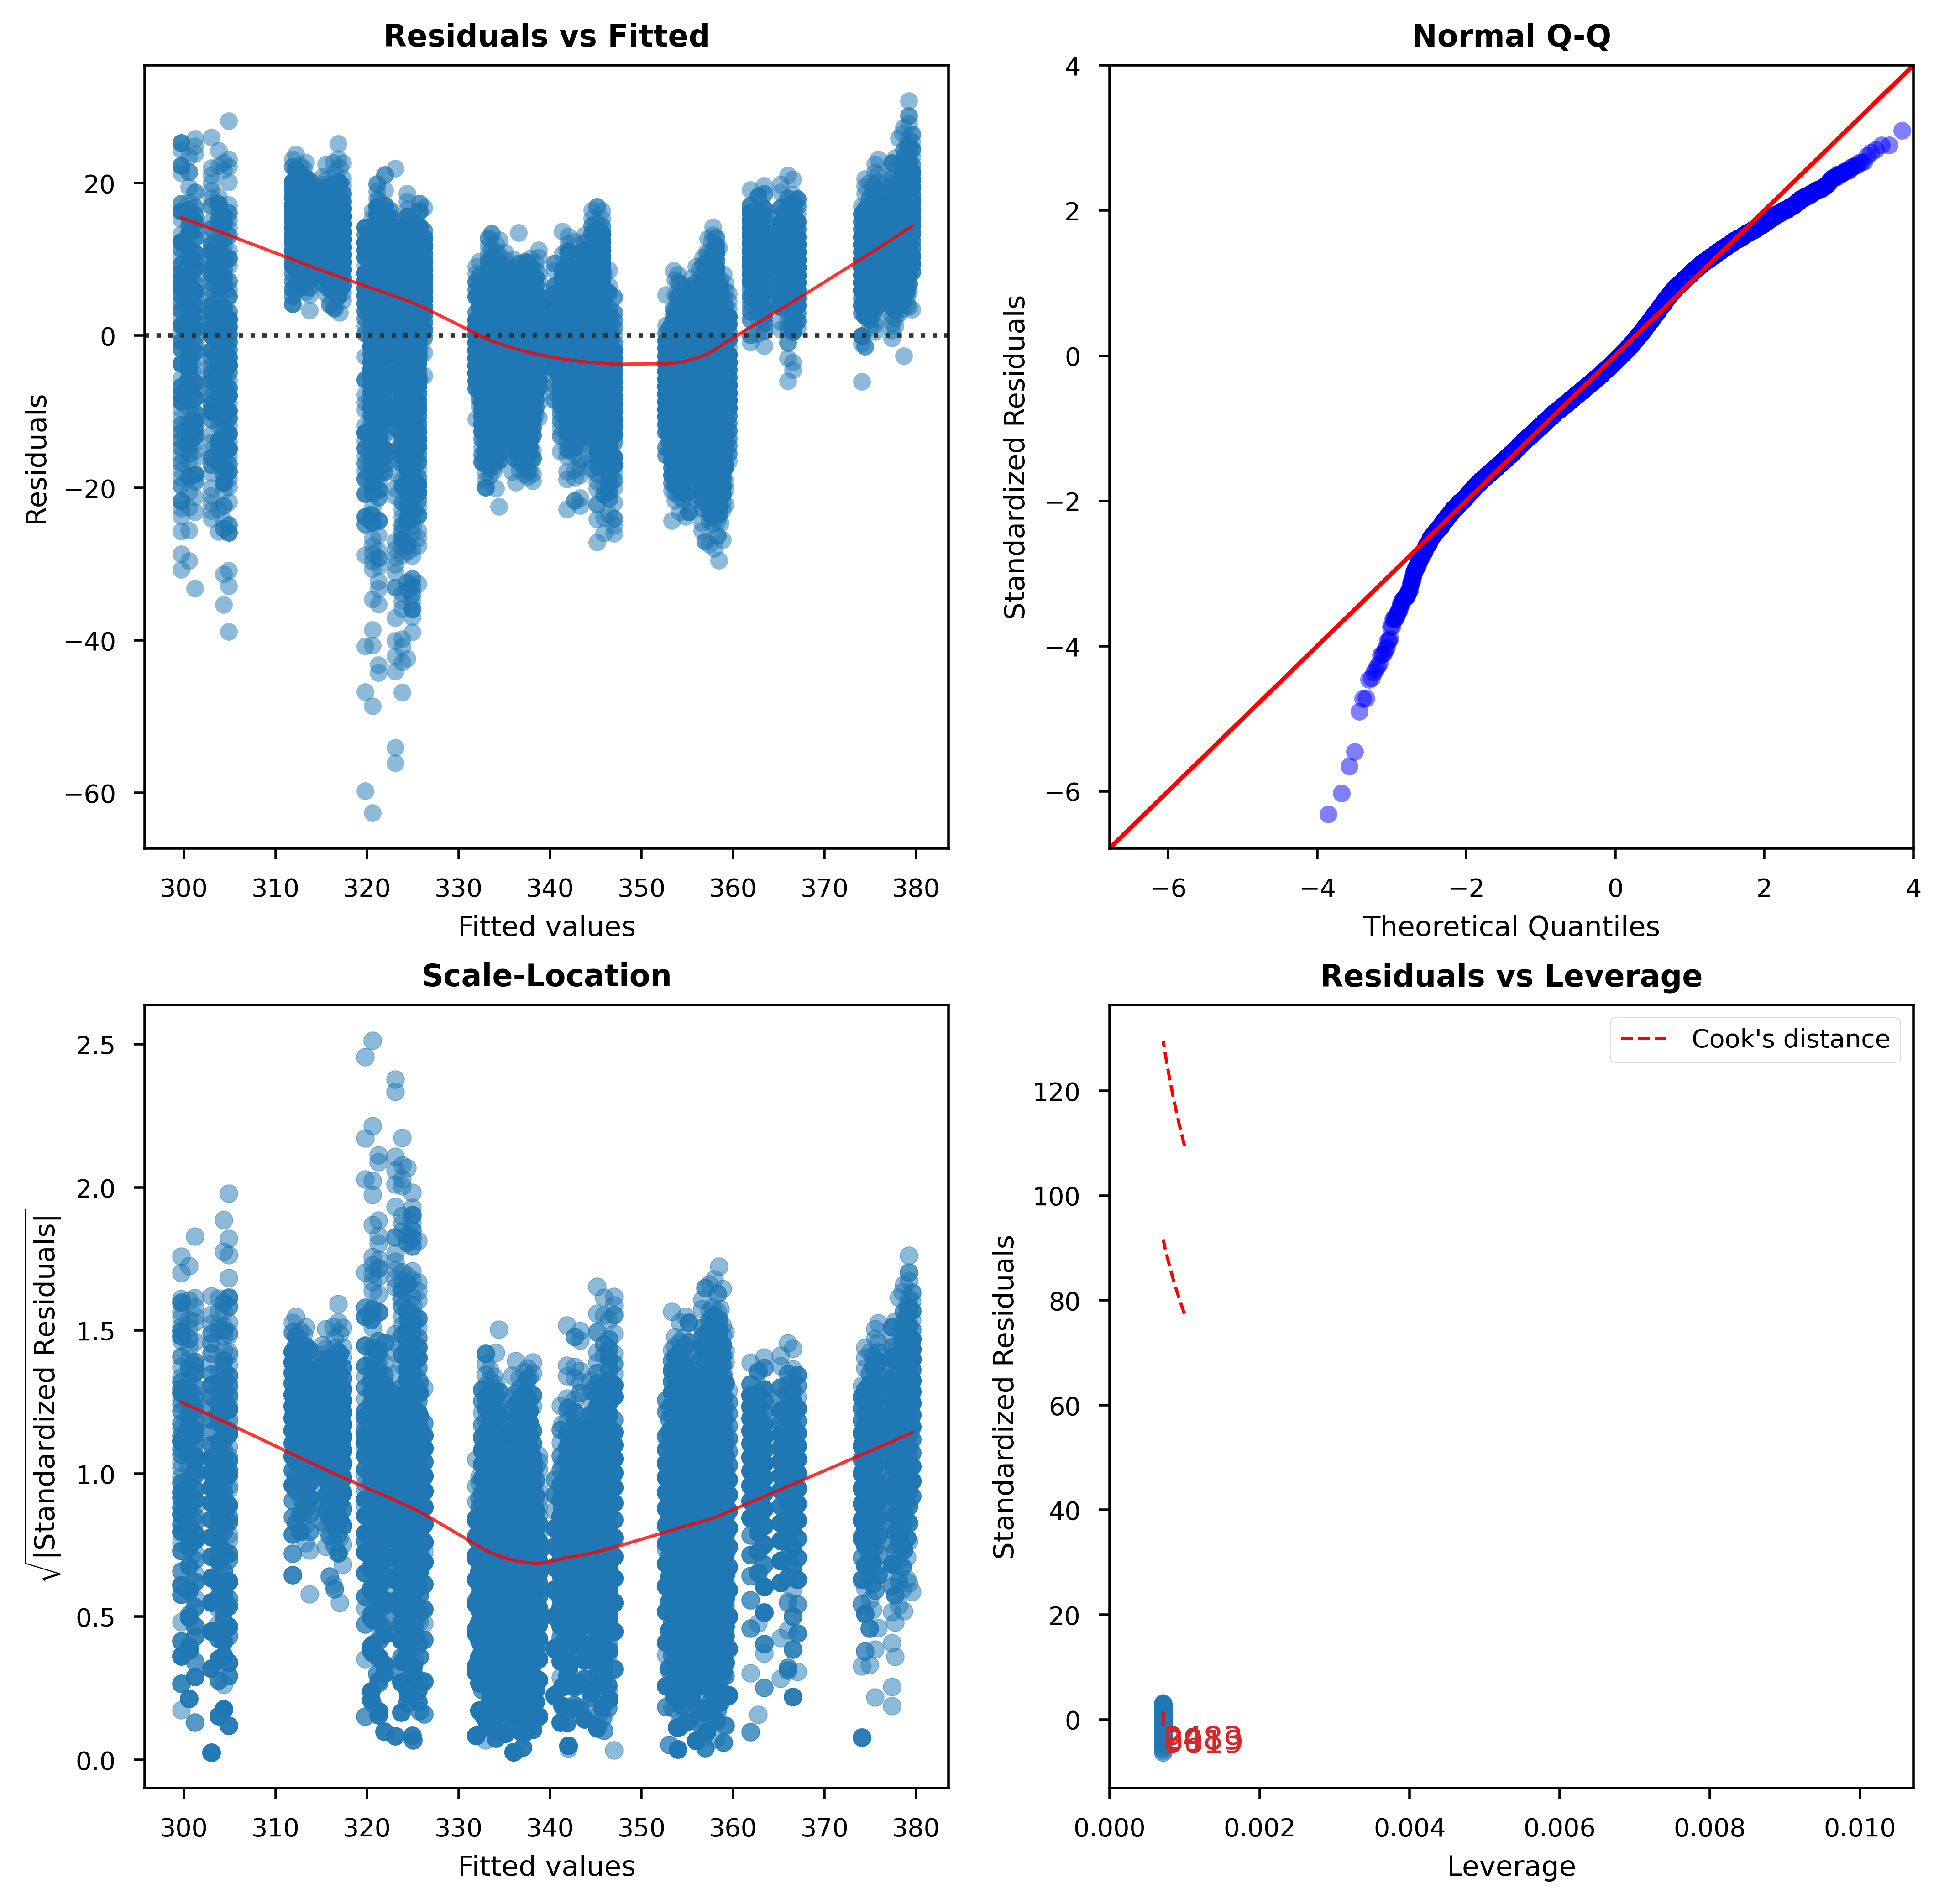

             Features  VIF Factor
3   Backend=Not delay        1.00
1      Core=Not delay        1.00
2    Labor=Full labor        1.00
5          NewStart=8        1.33
4         NewStart=10        1.33
6     BayPair=(19,16)        1.71
7     BayPair=(18,16)        1.71
8     BayPair=(19,17)        1.71
9     BayPair=(20,15)        1.71
11    BayPair=(20,17)        1.71
10    BayPair=(20,16)        1.71
0               const       12.00


In [65]:
cls_main_effects = Linear_Reg_Diagnostic(regr_main_effects)
fig, ax = cls_main_effects()

## Regression Full

In [33]:
X = df_X[['Core=Not delay','Labor=Full labor','Backend=Not delay','NewStart=10','NewStart=8',
          'BayPair=(19,16)','BayPair=(18,16)','BayPair=(19,17)','BayPair=(20,15)',
         'BayPair=(20,16)','BayPair=(20,17)',
         'Interaction(Core = Not delay,Labor = Full labor)',
          'Interaction(Core = Not delay,Backend = Not delay)',
           'Interaction(Core = Not delay,NewStart = 10)',
           'Interaction(Core = Not delay,NewStart = 8)',
          'Interaction(Core = Not delay,BayPair = (18, 16))',
       'Interaction(Core = Not delay,BayPair = (19, 16))',
       'Interaction(Core = Not delay,BayPair = (19, 17))',
       'Interaction(Core = Not delay,BayPair = (20, 15))',
       'Interaction(Core = Not delay,BayPair = (20, 16))',
       'Interaction(Core = Not delay,BayPair = (20, 17))',
       'Interaction(Labor = Full labor,Backend = Not delay)',
       'Interaction(Labor = Full labor,NewStart = 10)',
       'Interaction(Labor = Full labor,NewStart = 8)',
       'Interaction(Labor = Full labor,BayPair = (18, 16))',
       'Interaction(Labor = Full labor,BayPair = (19, 16))',
       'Interaction(Labor = Full labor,BayPair = (19, 17))',
       'Interaction(Labor = Full labor,BayPair = (20, 15))',
       'Interaction(Labor = Full labor,BayPair = (20, 16))',
       'Interaction(Labor = Full labor,BayPair = (20, 17))',
       'Interaction(Backend = Not delay,NewStart = 10)',
       'Interaction(Backend = Not delay,NewStart = 8)',
       'Interaction(Backend = Not delay,BayPair = (18, 16))',
       'Interaction(Backend = Not delay,BayPair = (19, 16))',
       'Interaction(Backend = Not delay,BayPair = (19, 17))',
       'Interaction(Backend = Not delay,BayPair = (20, 15))',
       'Interaction(Backend = Not delay,BayPair = (20, 16))',
       'Interaction(Backend = Not delay,BayPair = (20, 17))',
       'Interaction(NewStart = 10,BayPair = (18, 16))',
       'Interaction(NewStart = 10,BayPair = (19, 16))',
       'Interaction(NewStart = 10,BayPair = (19, 17))',
       'Interaction(NewStart = 10,BayPair = (20, 15))',
       'Interaction(NewStart = 10,BayPair = (20, 16))',
       'Interaction(NewStart = 10,BayPair = (20, 17))',
       'Interaction(NewStart = 8,BayPair = (18, 16))',
       'Interaction(NewStart = 8,BayPair = (19, 16))',
       'Interaction(NewStart = 8,BayPair = (19, 17))',
       'Interaction(NewStart = 8,BayPair = (20, 15))',
       'Interaction(NewStart = 8,BayPair = (20, 16))',
       'Interaction(NewStart = 8,BayPair = (20, 17))'
         ]]
X = sm.add_constant(X)

In [34]:
model_main_effects = sm.OLS(y,X)
regr_full_effects = model_main_effects.fit()
regr_full_effects.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 annual   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2955.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:27:25   Log-Likelihood:                -56117.
No. Observations:               16800   AIC:                         1.123e+05
Df Residuals:                   16749   BIC:                         1.127e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                 309.6126      0.377    821.447      0.000     308.874     310.351
Core=Not delay                                          0.4625      0.350      1.321      0.186      -0.224       1.149
Labor=Full labor                                        6.2104      0.350     17.739      0.000       5.524       6.897
Backend=Not delay                                      17.7175      0.350     50.608      0.000      17.031      18.404
NewStart=10                                            15.5609      0.409     38.063      0.000      14.760      16.362
NewStart=8                                             15.2816      0.409     37.380      0.000      14.480      16.083
BayPair=(19,16)                                         1.1704      0.484      2.420      0.016       0.222       2.119
BayPair=(18,16)                                         0.3588      0.484      0.742      0.458      -0.589       1.307
BayPair=(19,17)                                        -0.1533      0.484     -0.317      0.751      -1.101       0.795
BayPair=(20,15)                                        -0.7271      0.484     -1.503      0.133      -1.675       0.221
BayPair=(20,16)                                        -0.2358      0.484     -0.488      0.626      -1.184       0.712
BayPair=(20,17)                                        -1.7871      0.484     -3.694      0.000      -2.735      -0.839
Interaction(Core = Not delay,Labor = Full labor)       23.9852      0.211    113.614      0.000      23.571      24.399
Interaction(Core = Not delay,Backend = Not delay)      12.9024      0.211     61.116      0.000      12.489      13.316
Interaction(Core = Not delay,NewStart = 10)            -1.4232      0.259     -5.504      0.000      -1.930      -0.916
Interaction(Core = Not delay,NewStart = 8)             -1.2007      0.259     -4.644      0.000      -1.708      -0.694
Interaction(Core = Not delay,BayPair = (18, 16))        1.7975      0.395      4.551      0.000       1.023       2.572
Interaction(Core = Not delay,BayPair = (19, 16))        2.8975      0.395      7.336      0.000       2.123       3.672
Interaction(Core = Not delay,BayPair = (19, 17))        4.2883      0.395     10.858      0.000       3.514       5.062
Interaction(Core = Not delay,BayPair = (20, 15))        0.6733      0.395      1.705      0.088      -0.101       1.447
Interaction(Core = Not delay,BayPair = (20, 16))        3.8017      0.395      9.626      0.000       3.028       4.576
Interaction(Core = Not delay,BayPair = (20, 17))        5.4650      0.395     13.837      0.000       4.691       6.239
Interaction(Labor = Full labor,Backend = Not delay)     3.8362      0.211     18.17

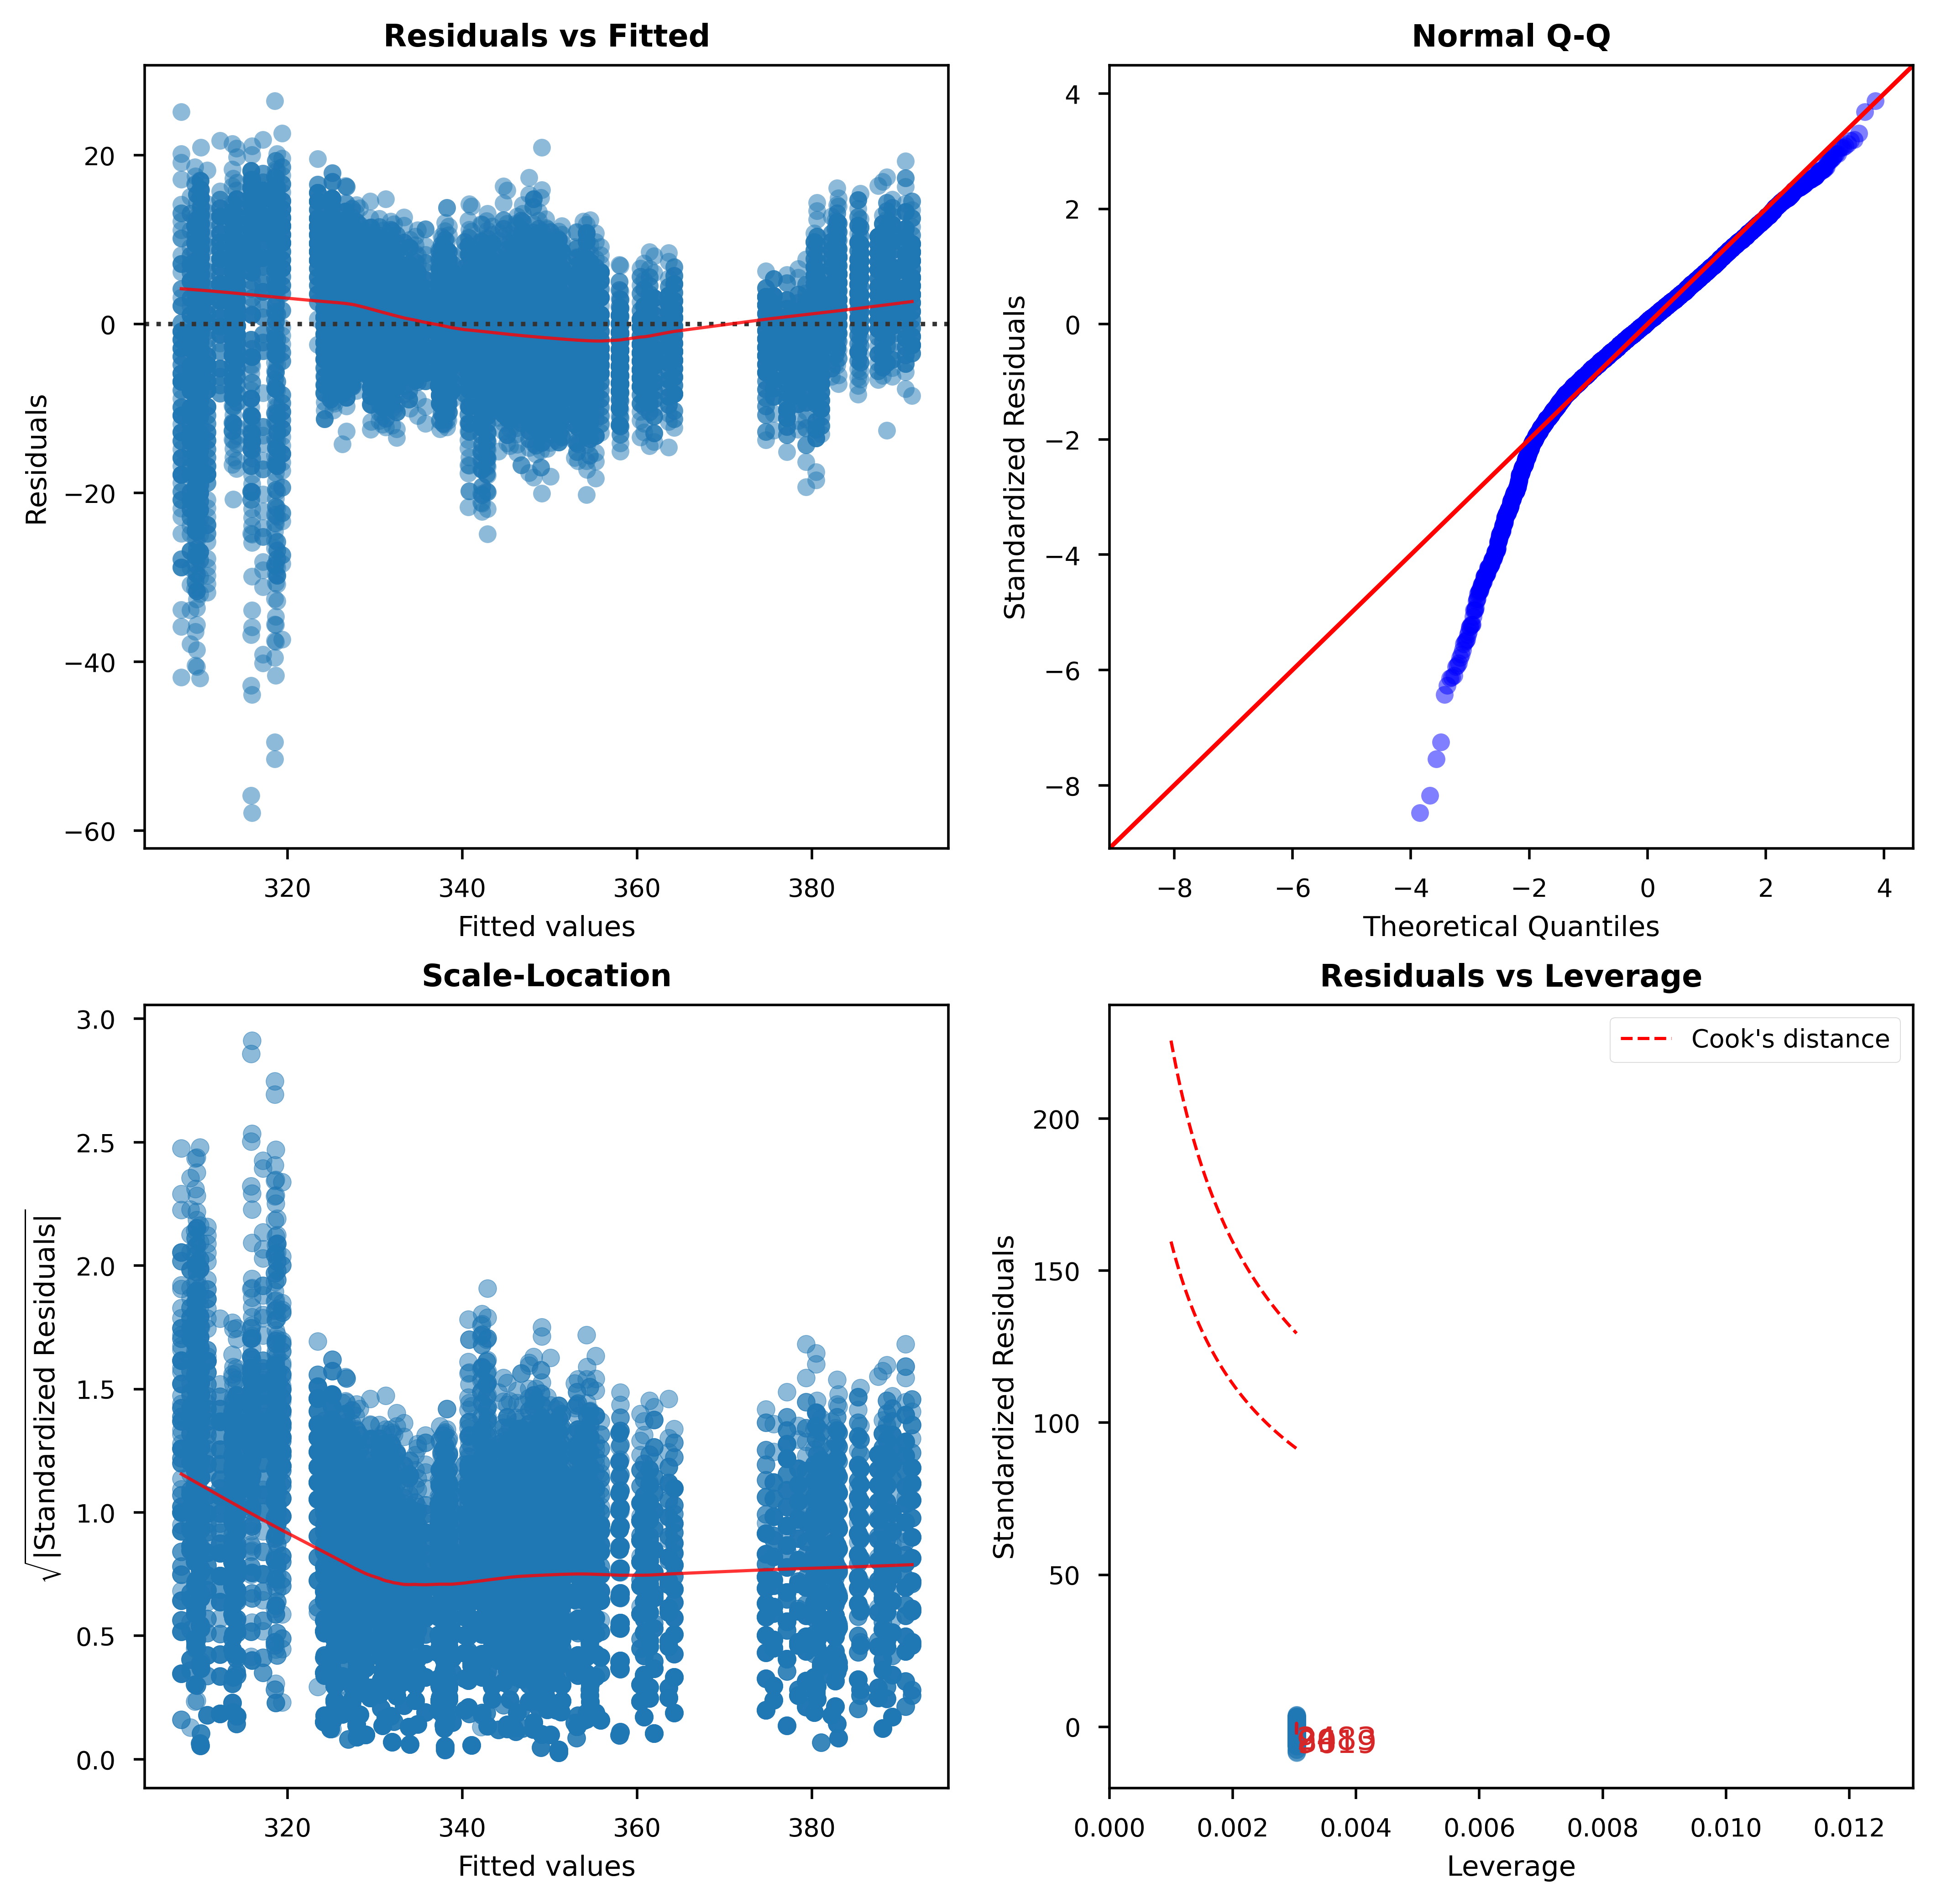

                                             Features  VIF Factor
22  Interaction(Labor = Full labor,Backend = Not d...        3.00
13  Interaction(Core = Not delay,Backend = Not delay)        3.00
12   Interaction(Core = Not delay,Labor = Full labor)        3.00
23      Interaction(Labor = Full labor,NewStart = 10)        3.33
14        Interaction(Core = Not delay,NewStart = 10)        3.33
24       Interaction(Labor = Full labor,NewStart = 8)        3.33
15         Interaction(Core = Not delay,NewStart = 8)        3.33
32      Interaction(Backend = Not delay,NewStart = 8)        3.33
31     Interaction(Backend = Not delay,NewStart = 10)        3.33
25  Interaction(Labor = Full labor,BayPair = (18, ...        3.71
35  Interaction(Backend = Not delay,BayPair = (19,...        3.71
28  Interaction(Labor = Full labor,BayPair = (20, ...        3.71
30  Interaction(Labor = Full labor,BayPair = (20, ...        3.71
17   Interaction(Core = Not delay,BayPair = (19, 16))        3.71
16   Inter

In [37]:
cls_full_effects = Linear_Reg_Diagnostic(regr_full_effects)
fig, ax = cls_full_effects()

## Weighted Regression Full

In [38]:
# Step 1. Calculate residuals
resid = regr_full_effects.resid

In [39]:
# step 2. calculate resid^2
resid_sqr = [i**2 for i in resid]

In [40]:
# step 3. calculate the average values of resid_sqr in each scenario
avg_resid_sqr = []
for i in range(168):
    sum_v = sum(resid_sqr[100*i:100*i+100])
    avg_resid_sqr.append(sum_v/(100 - regr_full_effects.df_model))

In [41]:
# step 4. calculate the weight
weight = [math.sqrt(i) for i in avg_resid_sqr]

In [42]:
weight_vector = []
for i in range(168):
    weight_vector += [1/weight[i] for j in range(100)]

In [43]:
weight_vector

[0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.0473882

In [44]:
#Autofit
mod_wls = sm.WLS(y,X,weights = weight_vector)
res_wls = mod_wls.fit()

In [45]:
res_wls.params.values

array([ 3.13737033e+02, -2.01041386e+00,  4.06101030e+00,  1.39975962e+01,
        1.28649346e+01,  1.24947903e+01,  7.21180849e-01,  8.30028632e-02,
       -4.97290004e-01, -9.93411043e-01, -1.06777165e+00, -2.24190438e+00,
        2.45001211e+01,  1.47504483e+01, -4.17905235e-01, -1.89674647e-01,
        2.08618079e+00,  3.02888070e+00,  4.43271738e+00,  8.29321043e-01,
        4.00288421e+00,  5.48613756e+00,  5.13403075e+00, -2.03432749e+00,
       -2.17639321e+00,  1.02367581e+00,  1.61033053e+00,  3.65523892e+00,
        1.10307396e+00,  3.37623254e+00,  4.89464608e+00, -3.29616977e+00,
       -3.32368445e+00, -6.97335548e-01, -1.74950330e+00, -2.03998490e+00,
       -2.78921767e-02, -1.81759444e+00, -2.14055199e+00, -1.25696232e-01,
        1.35583915e+00,  2.94476275e+00,  1.38582329e+00,  3.21845065e+00,
        4.78972442e+00,  4.80367008e-01,  1.49488390e+00,  2.73054743e+00,
        1.15578566e+00,  3.10830621e+00,  4.43549671e+00])

In [60]:
res_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 annual   R-squared:                       0.912
Model:                            WLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3452.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:58:15   Log-Likelihood:                -53663.
No. Observations:               16800   AIC:                         1.074e+05
Df Residuals:                   16749   BIC:                         1.078e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                 313.7370      0.391    802.223      0.000     312.970     314.504
Core=Not delay                                         -2.0104      0.324     -6.214      0.000      -2.645      -1.376
Labor=Full labor                                        4.0610      0.320     12.702      0.000       3.434       4.688
Backend=Not delay                                      13.9976      0.322     43.409      0.000      13.366      14.630
NewStart=10                                            12.8649      0.381     33.780      0.000      12.118      13.611
NewStart=8                                             12.4948      0.380     32.916      0.000      11.751      13.239
BayPair=(19,16)                                         0.7212      0.468      1.540      0.124      -0.197       1.639
BayPair=(18,16)                                         0.0830      0.466      0.178      0.859      -0.830       0.996
BayPair=(19,17)                                        -0.4973      0.474     -1.049      0.294      -1.427       0.432
BayPair=(20,15)                                        -0.9934      0.463     -2.146      0.032      -1.901      -0.086
BayPair=(20,16)                                        -1.0678      0.467     -2.288      0.022      -1.983      -0.153
BayPair=(20,17)                                        -2.2419      0.480     -4.670      0.000      -3.183      -1.301
Interaction(Core = Not delay,Labor = Full labor)       24.5001      0.180    135.832      0.000      24.147      24.854
Interaction(Core = Not delay,Backend = Not delay)      14.7504      0.182     80.931      0.000      14.393      15.108
Interaction(Core = Not delay,NewStart = 10)            -0.4179      0.236     -1.770      0.077      -0.881       0.045
Interaction(Core = Not delay,NewStart = 8)             -0.1897      0.237     -0.802      0.423      -0.653       0.274
Interaction(Core = Not delay,BayPair = (18, 16))        2.0862      0.333      6.274      0.000       1.434       2.738
Interaction(Core = Not delay,BayPair = (19, 16))        3.0289      0.332      9.128      0.000       2.378       3.679
Interaction(Core = Not delay,BayPair = (19, 17))        4.4327      0.334     13.256      0.000       3.777       5.088
Interaction(Core = Not delay,BayPair = (20, 15))        0.8293      0.329      2.519      0.012       0.184       1.475
Interaction(Core = Not delay,BayPair = (20, 16))        4.0029      0.330     12.116      0.000       3.355       4.650
Interaction(Core = Not delay,BayPair = (20, 17))        5.4861      0.337     16.302      0.000       4.826       6.146
Interaction(Labor = Full labor,Backend = Not delay)     5.1340      0.181     28.33

In [47]:
res_wls.params

const                                                  313.737033
Core=Not delay                                          -2.010414
Labor=Full labor                                         4.061010
Backend=Not delay                                       13.997596
NewStart=10                                             12.864935
NewStart=8                                              12.494790
BayPair=(19,16)                                          0.721181
BayPair=(18,16)                                          0.083003
BayPair=(19,17)                                         -0.497290
BayPair=(20,15)                                         -0.993411
BayPair=(20,16)                                         -1.067772
BayPair=(20,17)                                         -2.241904
Interaction(Core = Not delay,Labor = Full labor)        24.500121
Interaction(Core = Not delay,Backend = Not delay)       14.750448
Interaction(Core = Not delay,NewStart = 10)             -0.417905
Interactio

In [48]:
resid_wls = res_wls.resid

In [49]:
resid_wls

0         4.201957
1       -21.798043
2       -16.798043
3        10.201957
4         6.201957
           ...    
16795    -4.518929
16796    -3.518929
16797    -6.518929
16798   -11.518929
16799    -3.518929
Length: 16800, dtype: float64

In [64]:
weight_vector

[0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.04738828502872506,
 0.0473882

In [50]:
X_WLS = X.copy()
for k in X.columns:
    X_WLS[k] = X[k]*weight_vector
y_WLS = [y[i]*weight_vector[i] for i in range(N)]
model_wls_2 = sm.OLS(y_WLS,X_WLS)
regr_wls_2 = model_wls_2.fit()
regr_wls_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.525e+06
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        12:31:25   Log-Likelihood:                         -17486.
No. Observations:               16800   AIC:                                  3.507e+04
Df Residuals:                   16749   BIC:                                  3.547e+04
Df Model:                          51                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                 317.6462      0.411    772.547      0.000     316.840     318.452
Core=Not delay                                         -4.3161      0.321    -13.451      0.000      -4.945      -3.687
Labor=Full labor                                        3.0385      0.309      9.821      0.000       2.432       3.645
Backend=Not delay                                      10.5071      0.320     32.825      0.000       9.880      11.135
NewStart=10                                             9.5271      0.390     24.428      0.000       8.763      10.292
NewStart=8                                              9.1256      0.387     23.587      0.000       8.367       9.884
BayPair=(19,16)                                         0.7316      0.450      1.624      0.104      -0.151       1.615
BayPair=(18,16)                                         0.0955      0.446      0.214      0.830      -0.778       0.969
BayPair=(19,17)                                        -0.4063      0.465     -0.874      0.382      -1.317       0.505
BayPair=(20,15)                                        -0.9978      0.437     -2.283      0.022      -1.855      -0.141
BayPair=(20,16)                                        -1.2909      0.450     -2.871      0.004      -2.172      -0.409
BayPair=(20,17)                                        -2.1725      0.478     -4.546      0.000      -3.109      -1.236
Interaction(Core = Not delay,Labor = Full labor)       24.5304      0.165    148.526      0.000      24.207      24.854
Interaction(Core = Not delay,Backend = Not delay)      16.1268      0.170     94.784      0.000      15.793      16.460
Interaction(Core = Not delay,NewStart = 10)             1.1919      0.239      4.990      0.000       0.724       1.660
Interaction(Core = Not delay,NewStart = 8)              1.4360      0.239      5.998      0.000       0.967       1.905
Interaction(Core = Not delay,BayPair = (18, 16))        2.1521      0.296      7.278      0.000       1.573       2.732
Interaction(Core = Not delay,BayPair = (19, 16))        2.9764      0.293     10.160      0.000       2.402       3.551
Interaction(Core = Not delay,BayPair = (19, 17))        4.3267      0.299     14.484      0.000       3.741       4.912
Interaction(Core = Not delay,BayPair = (20, 15))        0.9002      0.289      3.120      0.002       0.335       1.466
Interaction(Core = Not delay,BayPair = (20, 16))        3.9891      0.290     13.735      0.000       3.420       4.558
Interaction(Core = Not delay,BayPair = (20, 17))        5.3210      0.301     17.657      0.000       4.

In [436]:
X_WLS

const  Core=Not delay  Labor=Full labor  Backend=Not delay  \
0      0.051650        0.000000               0.0           0.000000   
1      0.051650        0.000000               0.0           0.000000   
2      0.051650        0.000000               0.0           0.000000   
3      0.051650        0.000000               0.0           0.000000   
4      0.051650        0.000000               0.0           0.000000   
...         ...             ...               ...                ...   
16795  0.109469        0.109469               0.0           0.109469   
16796  0.109469        0.109469               0.0           0.109469   
16797  0.109469        0.109469               0.0           0.109469   
16798  0.109469        0.109469               0.0           0.109469   
16799  0.109469        0.109469               0.0           0.109469   

       NewStart=10  NewStart=8  BayPair=(19,16)  BayPair=(18,16)  \
0         0.000000         0.0              0.0              0.0   
1         0.000000         0.0              0.0              0.0   
2         0.000000         0.0              0.0              0.0   
3         0.000000         0.0              0.0              0.0   
4         0.000000         0.0              0.0              0.0   
...            ...         ...              ...              ...   
16795     0.109469         0.0              0.0              0.0   
16796     0.109469         0.0              0.0              0.0   
16797     0.109469         0.0              0.0              0.0   
16798     0.109469         0.0              0.0              0.0   
16799     0.109469         0.0              0.0              0.0   

       BayPair=(19,17)  BayPair=(20,15)  ...  \
0                  0.0              0.0  ...   
1                  0.0              0.0  ...   
2                  0.0              0.0  ...   
3                  0.0              0.0  ...   
4                  0.0              0.0  ...   
...                ...              ...  ...   
16795              0.0              0.0  ...   
16796              0.0              0.0  ...   
16797              0.0              0.0  ...   
16798              0.0              0.0  ...   
16799              0.0              0.0  ...   

       Interaction(NewStart = 10,BayPair = (19, 17))  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
16795                                            0.0   
16796                                            0.0   
16797                                            0.0   
16798                                            0.0   
16799                                            0.0   

       Interaction(NewStart = 10,BayPair = (20, 15))  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
16795                                            0.0   
16796                                            0.0   
16797                                            0.0   
16798                                            0.0   
16799                                            0.0   

       Interaction(NewStart = 10,BayPair = (20, 16))  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
16795        

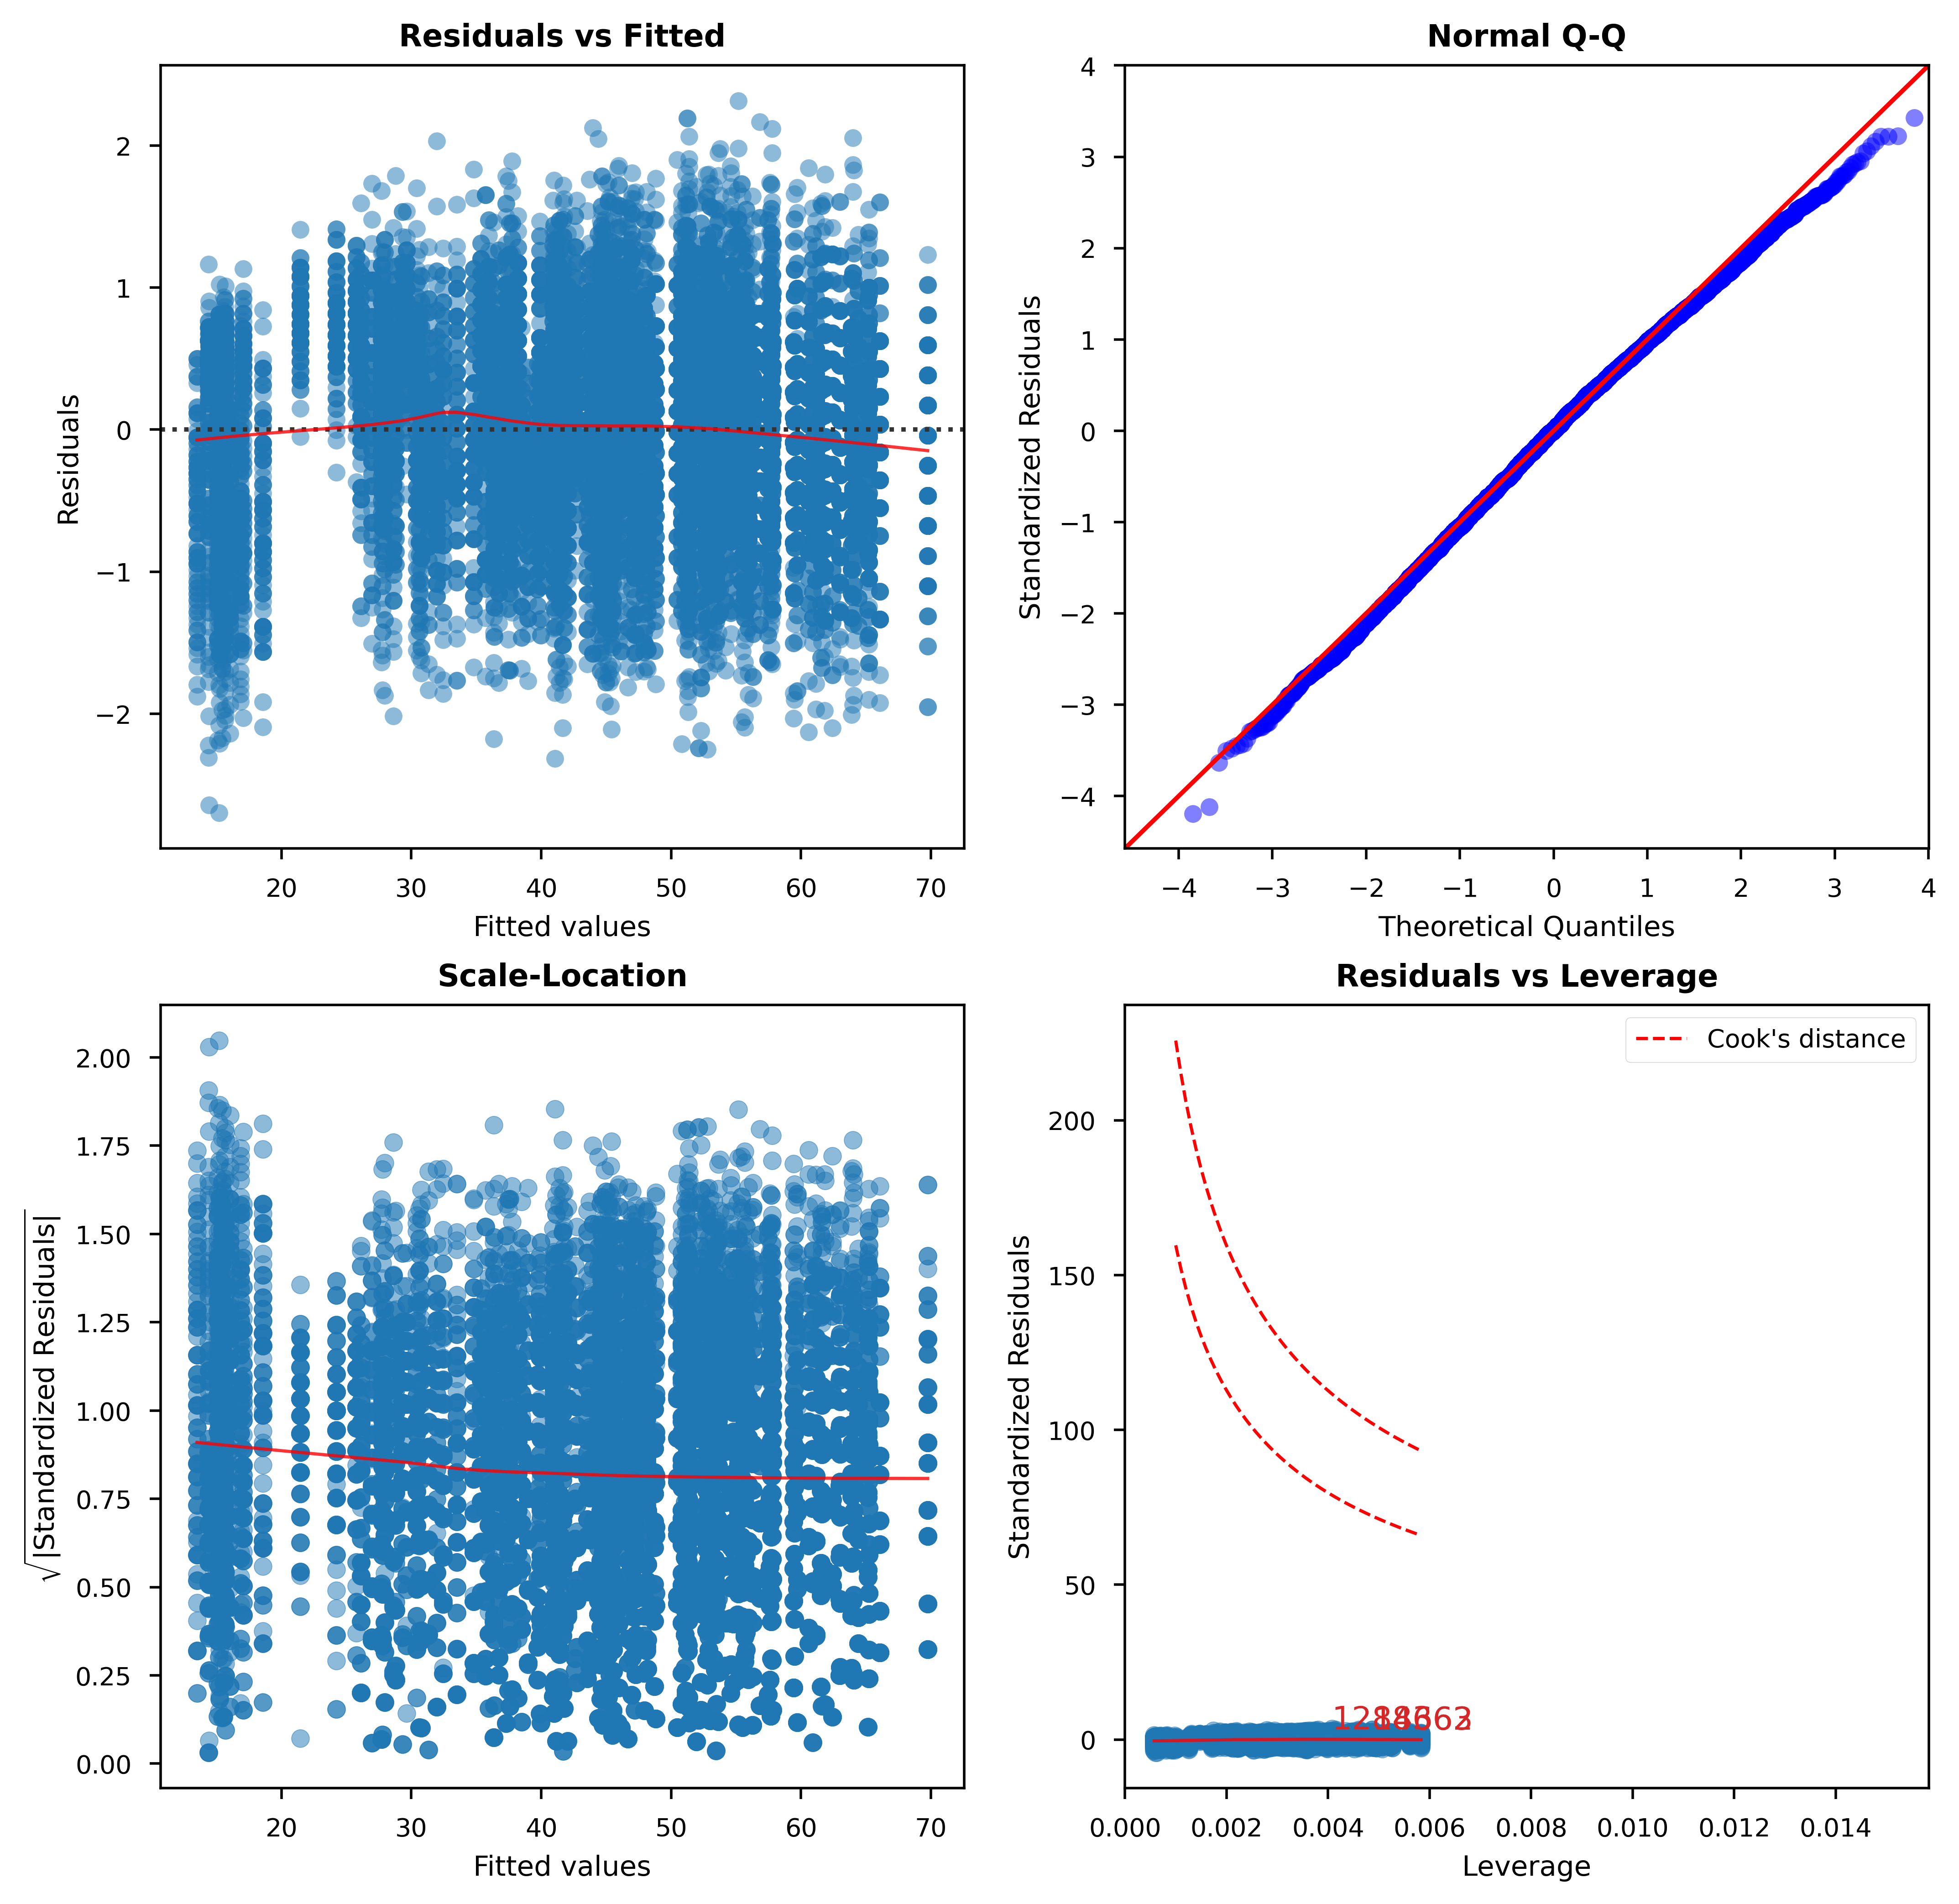

                                             Features  VIF Factor
18   Interaction(Core = Not delay,BayPair = (19, 17))        3.28
16   Interaction(Core = Not delay,BayPair = (18, 16))        3.43
21   Interaction(Core = Not delay,BayPair = (20, 17))        3.44
20   Interaction(Core = Not delay,BayPair = (20, 16))        3.52
17   Interaction(Core = Not delay,BayPair = (19, 16))        3.54
38  Interaction(Backend = Not delay,BayPair = (20,...        3.55
37  Interaction(Backend = Not delay,BayPair = (20,...        3.84
25  Interaction(Labor = Full labor,BayPair = (18, ...        3.85
13  Interaction(Core = Not delay,Backend = Not delay)        3.91
33  Interaction(Backend = Not delay,BayPair = (18,...        3.91
34  Interaction(Backend = Not delay,BayPair = (19,...        3.92
35  Interaction(Backend = Not delay,BayPair = (19,...        3.92
19   Interaction(Core = Not delay,BayPair = (20, 15))        3.94
30  Interaction(Labor = Full labor,BayPair = (20, ...        4.01
26  Intera

In [51]:
cls_wls_2 = Linear_Reg_Diagnostic(regr_wls_2)
fig, ax = cls_wls_2()

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

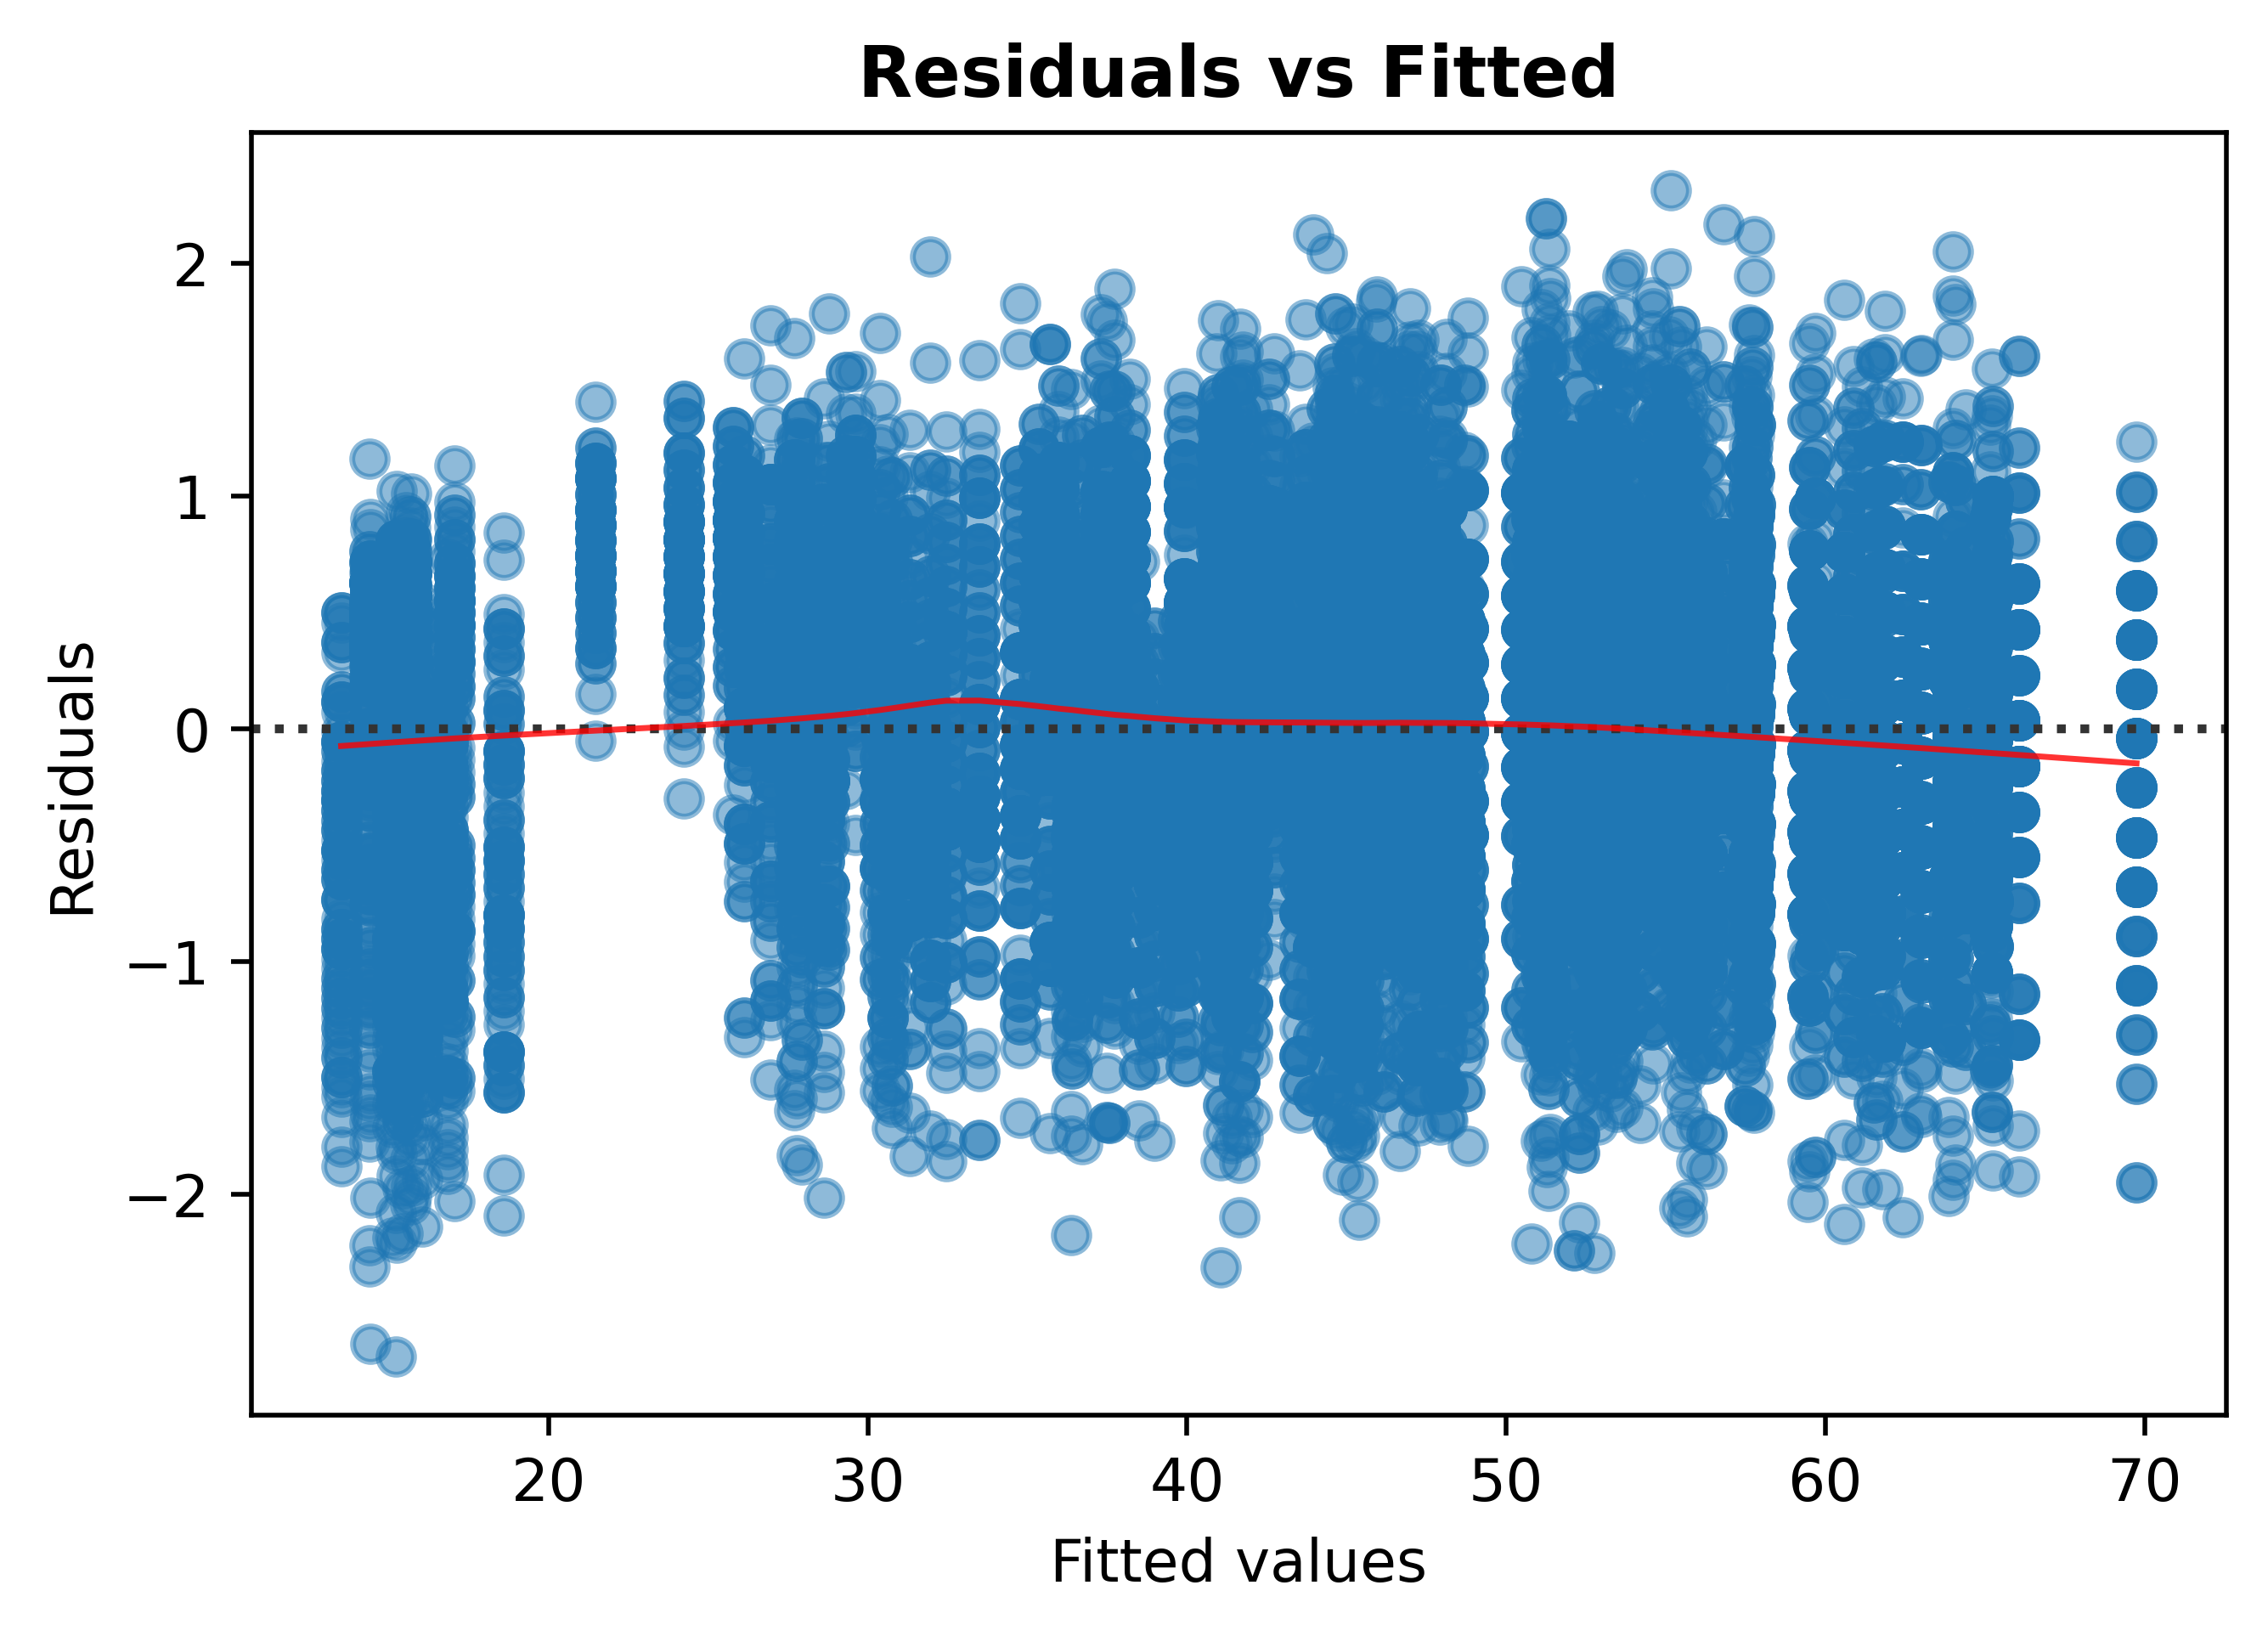

In [52]:
cls_wls_2.residual_plot()

### Lilliefors Test

In [53]:
testr = sm.stats.diagnostic.lilliefors(resid_wls)

In [54]:
testr # ksstat, pvalue

(0.06292489994807185, 1.8955496782079195e-178)

#### chi-squre test

In [55]:
scipy.stats.chisquare(resid_wls)

Power_divergenceResult(statistic=-3255793.2616342464, pvalue=1.0)

#### K-S Test 

In [56]:
scipy.stats.kstest(resid_wls,scipy.stats.norm.cdf)

KstestResult(statistic=0.35190340739771053, pvalue=0.0)

#### Durbin Watson Test

In [57]:
sm.stats.stattools.durbin_watson(resid_wls) # within the range of 1.5 and 2.5, we consider the autocorrelation not to be problematic

1.5048804894231842